In [39]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

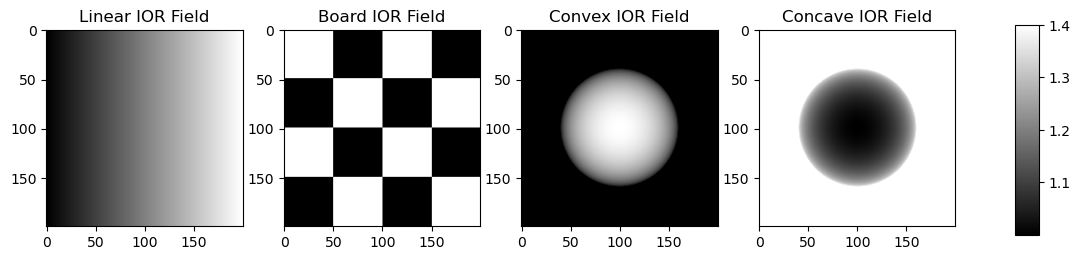

In [40]:
height, width = 200, 200
gradient = np.linspace(0, 0.4, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) + 1

tile_size = 50
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.4 + 1.0

x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
X, Y = np.meshgrid(x, y)
R = 0.6
r = np.sqrt(X**2 + Y**2)
n0, n1 = 1.4, 1.0
convex_lens_ior_field = n0 + (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

n0, n1 = 1.0, 0.6
concave_lens_ior_field = n0 - (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

plt.figure(figsize=(12, 3))
plt.subplot(141)
plt.imshow(linear_ior_field, cmap='gray')
plt.title('Linear IOR Field')
plt.subplot(142)
plt.imshow(board_ior_field, cmap='gray')
plt.title('Board IOR Field')
plt.subplot(143)
plt.imshow(convex_lens_ior_field, cmap='gray')
plt.title('Convex IOR Field')
plt.subplot(144)
plt.imshow(concave_lens_ior_field, cmap='gray')
plt.title('Concave IOR Field')

# share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()
# Figure 1: Different IOR fields for testing of light front propagation

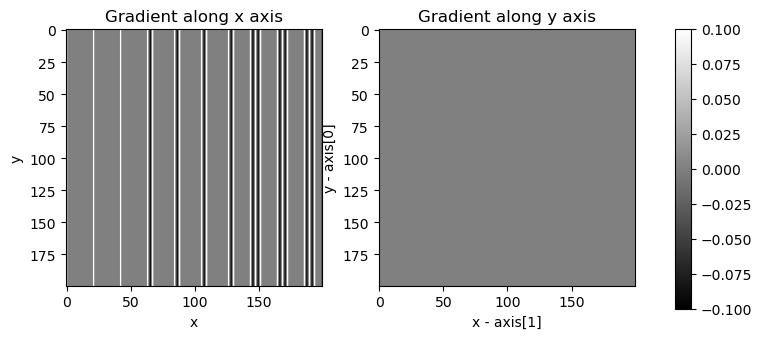

In [41]:
def compute_gradients(IOR):
    grad_x = np.gradient(IOR, axis=1)
    grad_y = np.gradient(IOR, axis=0)
    return grad_x, grad_y

grad_x, grad_y = compute_gradients(linear_ior_field)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient along x axis')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient along y axis')

plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()

In [42]:
field_size = 200
initial_wavefront_positions = [(0, i) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(field_size)]  # initial directions are all to the right

num_steps = 481
delta_t = 0.8
num_show_images = 6

test_ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field]

## 2. Update wavefront

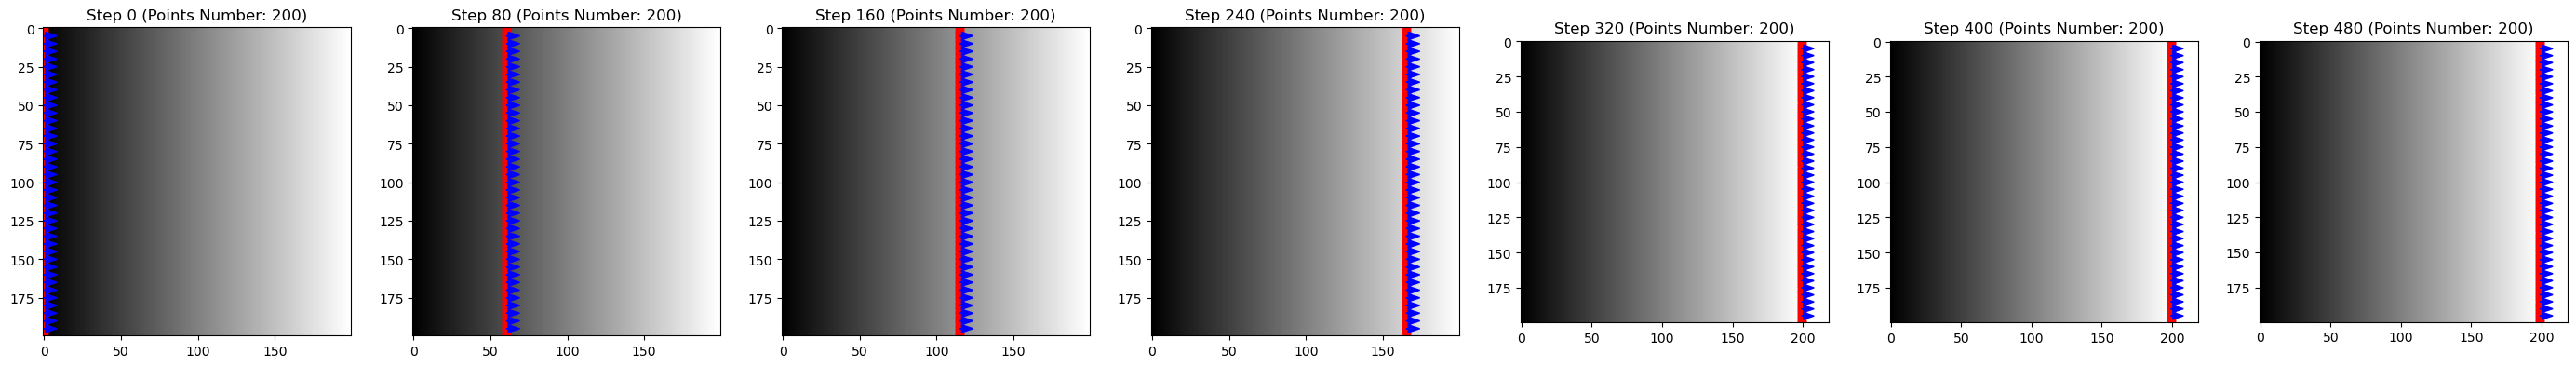

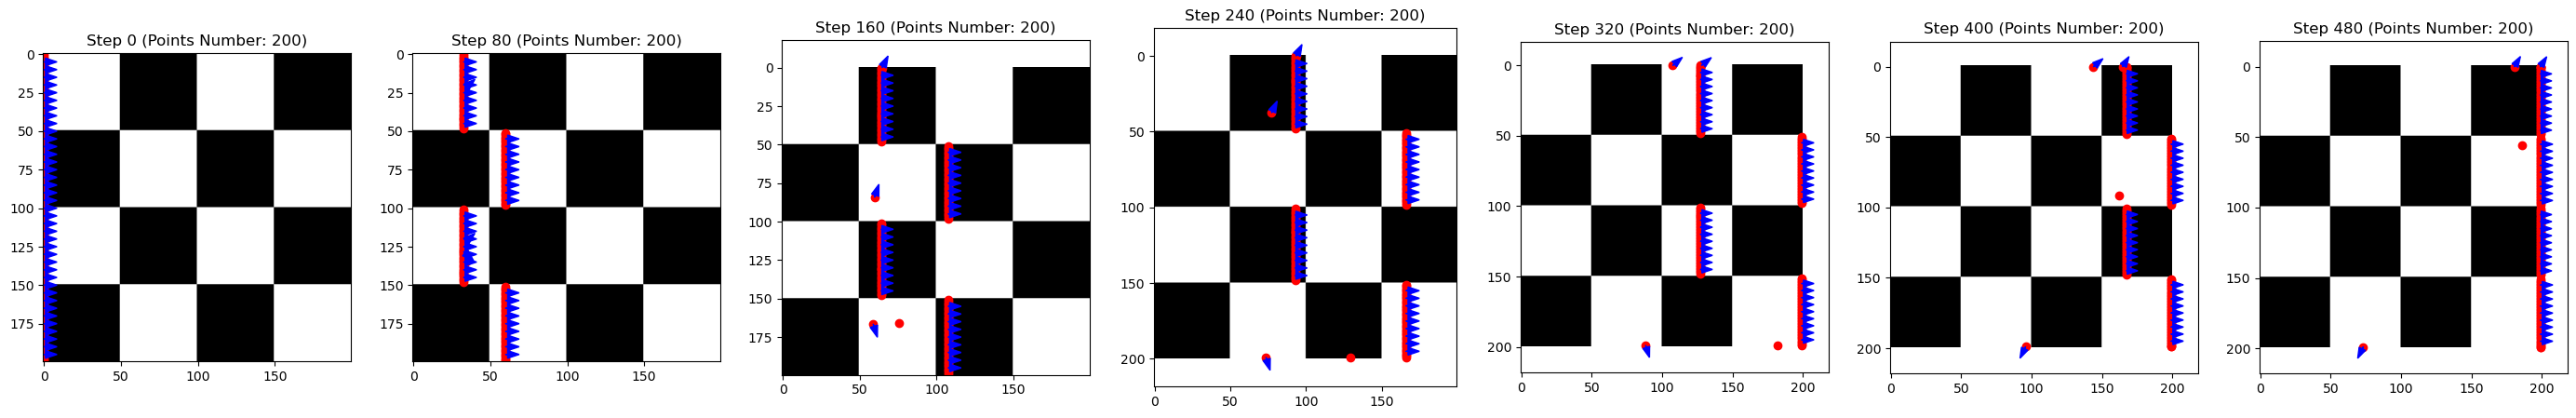

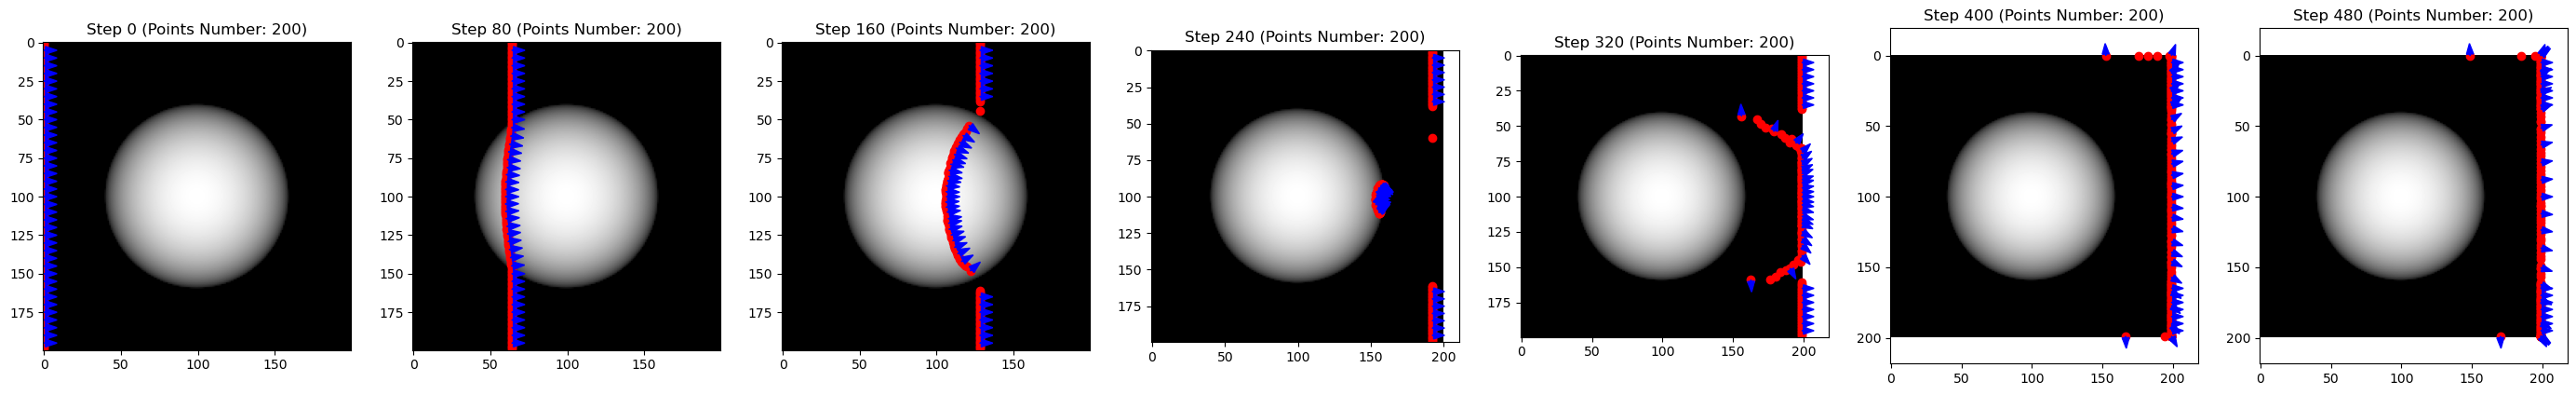

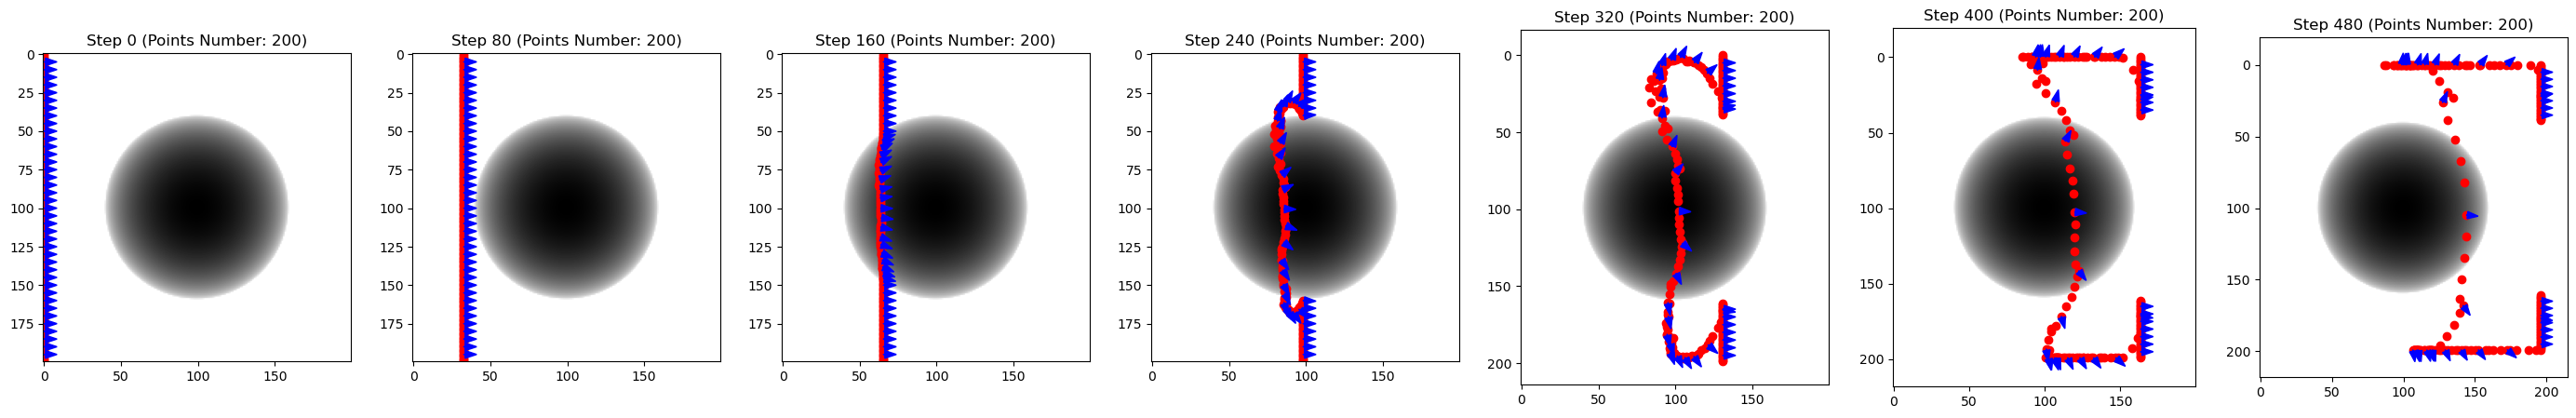

In [43]:
def update_wavefront(pos, dir, IOR, delta_t, refine_threshold):
    new_pos = []
    new_dir = []
    grad_x_ior, grad_y_ior = compute_gradients(IOR)
    for (x, y), (vx, vy) in zip(pos, dir):
        n = IOR[int(y), int(x)]
        # x_i+1 = x_i + delta_t * v_i / n^2
        # v_i+1 = v_i + delta_t * grad_n / n

        # calculate the new position
        new_x = x + delta_t * (vx / (n**2))
        new_y = y + delta_t * (vy / (n**2))

        # calculate the new direction
        nx = grad_x_ior[int(y), int(x)]
        ny = grad_y_ior[int(y), int(x)]
        new_vx = vx + delta_t * (nx / n)
        new_vy = vy + delta_t * (ny / n)

        # clip the new position to the boundary
        new_x = np.clip(new_x, 0, IOR.shape[1] - 1)
        new_y = np.clip(new_y, 0, IOR.shape[0] - 1)

        new_pos.append((new_x, new_y))
        new_dir.append((new_vx, new_vy))
    
    if refine_threshold is not None:
        refined_pos = []
        refined_dir = []
        for i in range(len(new_pos) - 1):
            refined_pos.append(new_pos[i])
            refined_dir.append(new_dir[i])
            dist = np.sqrt((new_pos[i+1][0] - new_pos[i][0])**2 + (new_pos[i+1][1] - new_pos[i][1])**2)
            if dist > refine_threshold:
                mid_x = (new_pos[i+1][0] + new_pos[i][0]) / 2
                mid_y = (new_pos[i+1][1] + new_pos[i][1]) / 2
                mid_vx = (new_dir[i+1][0] + new_dir[i][0]) / 2
                mid_vy = (new_dir[i+1][1] + new_dir[i][1]) / 2

                refined_pos.append((mid_x, mid_y))
                refined_dir.append((mid_vx, mid_vy))
        refined_pos.append(new_pos[-1])
        refined_dir.append(new_dir[-1])
        return refined_pos, refined_dir

    return new_pos, new_dir

def simulate_wavefront_propagation(cur_IOR, inital_wavefront_pos, initial_wavefront_dir, num_steps=200, delta_t=1.0, num_show_images=5, refine_threshold=None):
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]

    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_IOR, delta_t, refine_threshold)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)

    num_show_images = [i for i in range(0, num_steps, num_steps // num_show_images)]
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='gray')
        plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
        for j, (x, y) in enumerate(wavefront_pos_list[i]):
            if j != 0 and j % 5 == 0:
                plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=5)        
        plt.title(f'Step {i} (Points Number: {len(wavefront_pos_list[i])})')
    plt.show()


for cur_ior_field in test_ior_fields:
    simulate_wavefront_propagation(cur_ior_field, initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, num_show_images)
    

## 3. Update wavefront and refine wavefront by interpolation with threshold

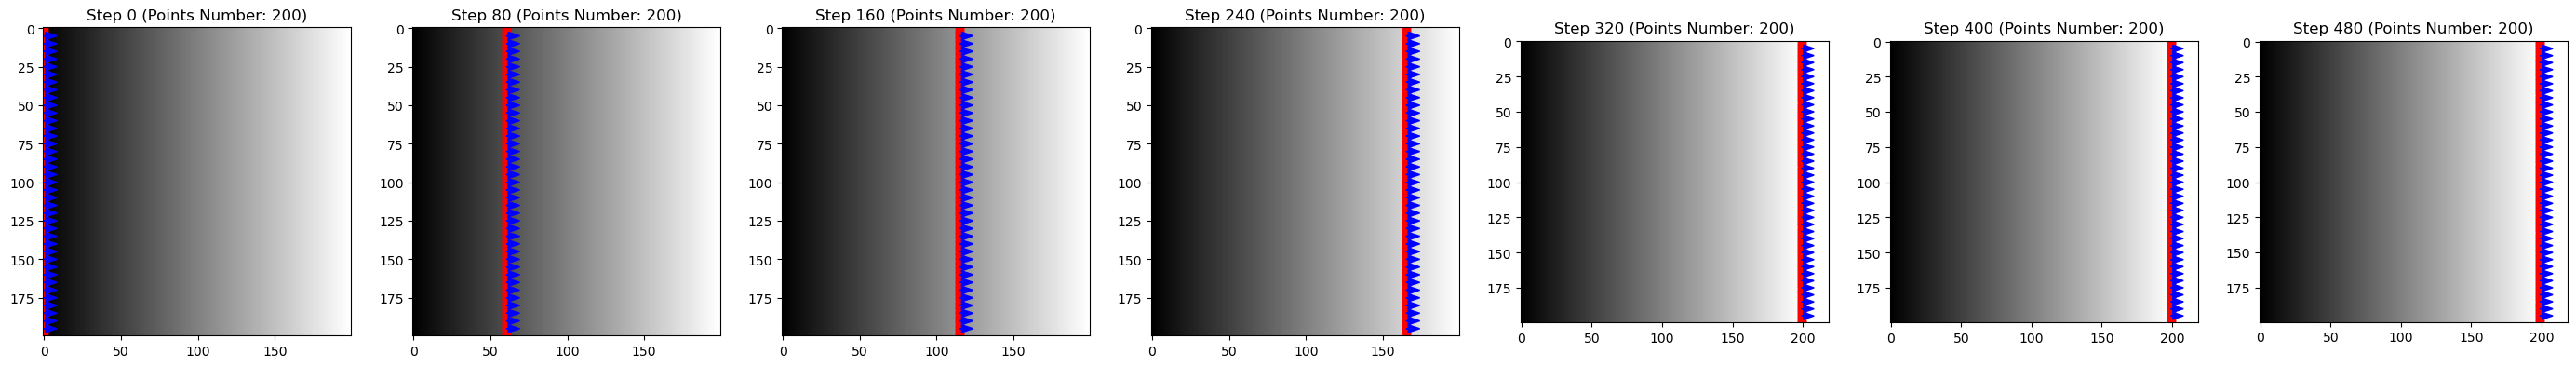

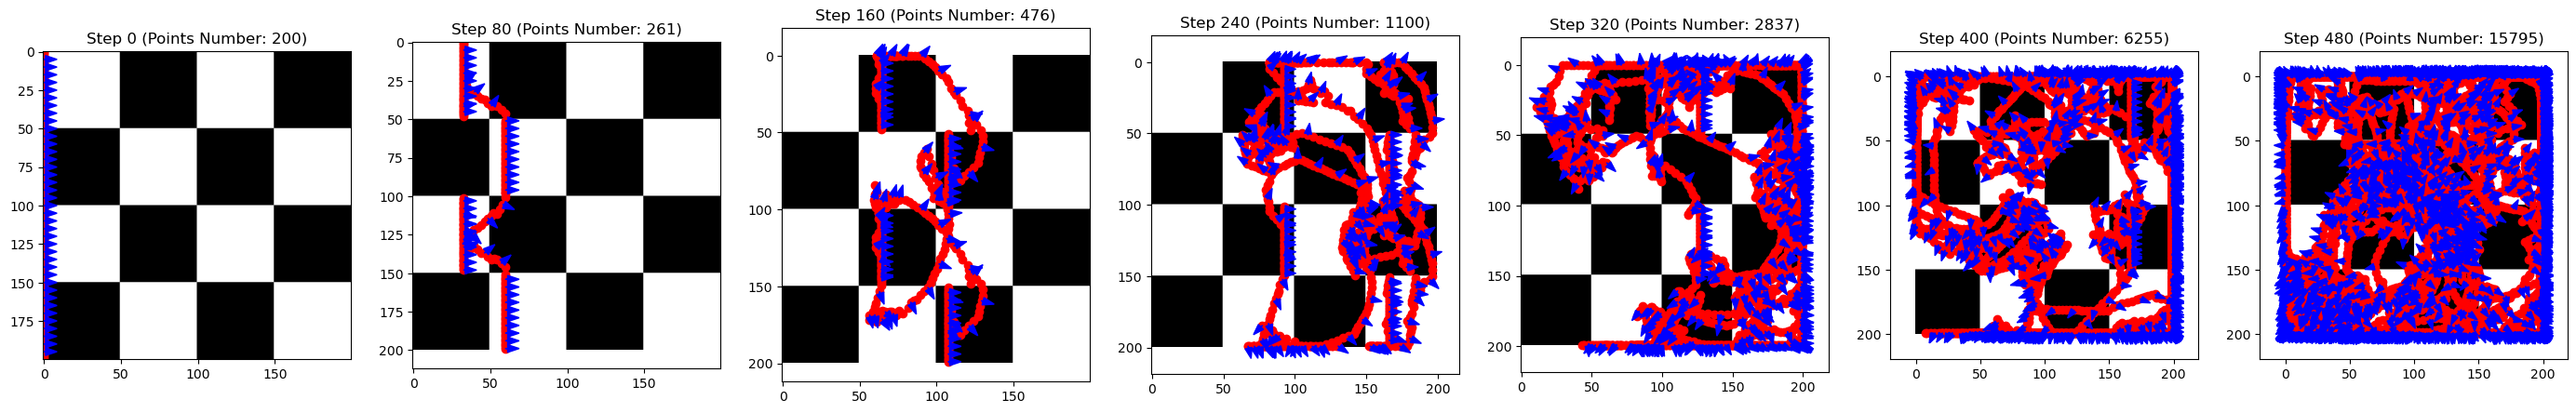

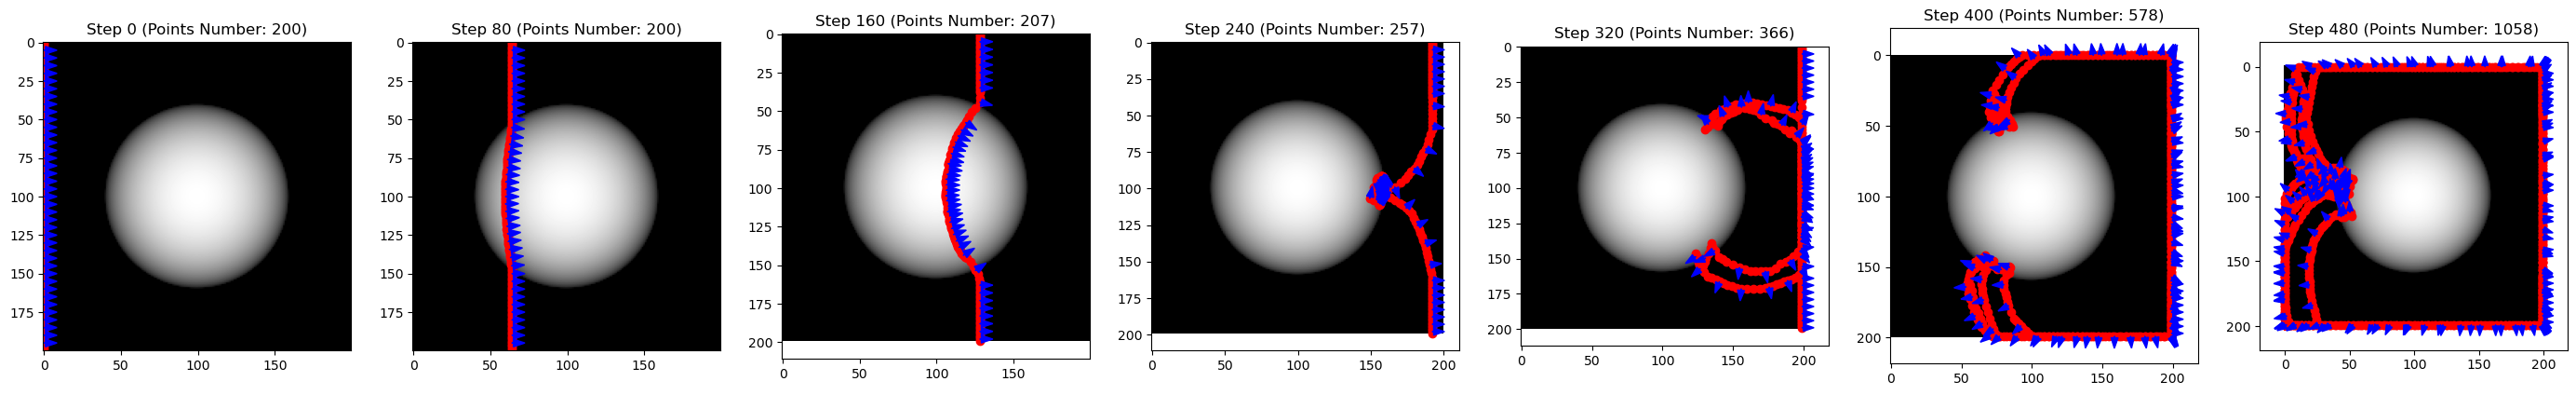

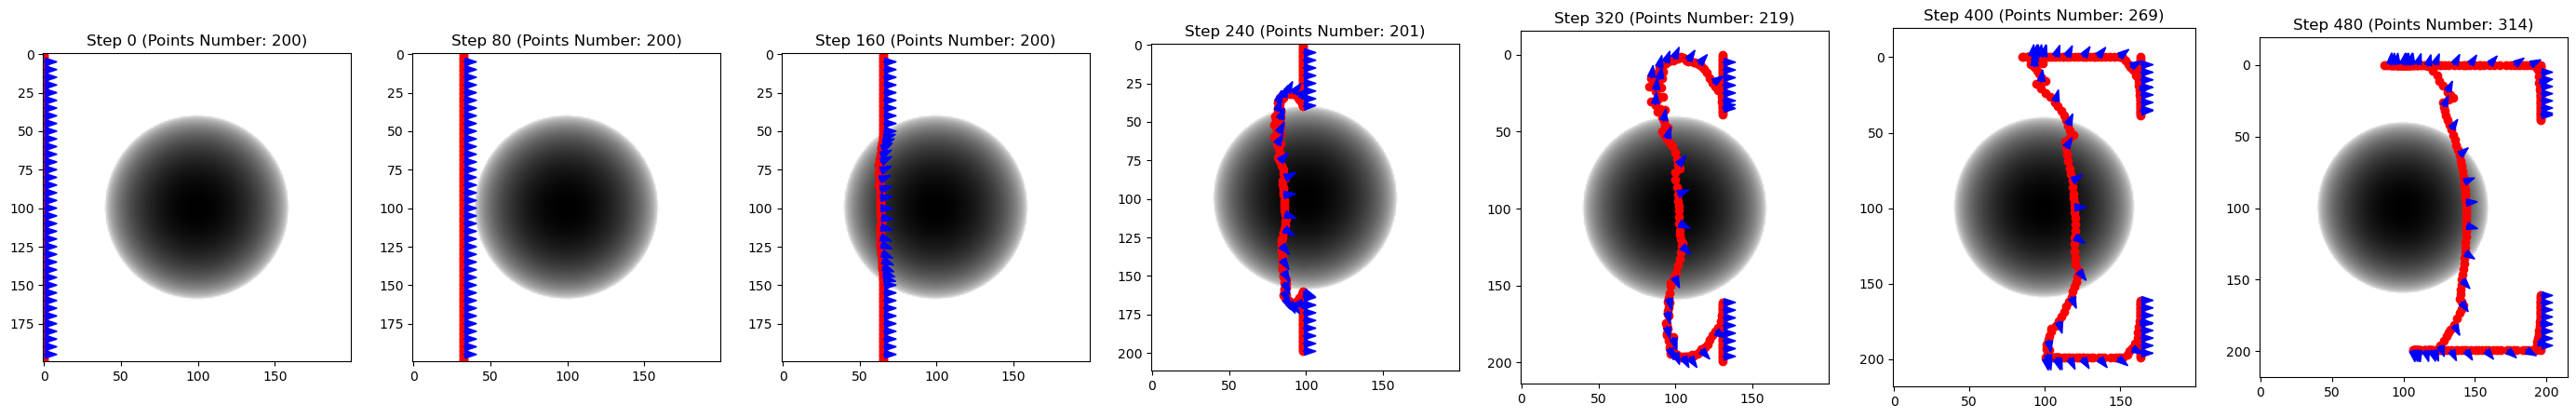

In [44]:
for cur_ior_field in test_ior_fields:
    simulate_wavefront_propagation(cur_ior_field, initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, num_show_images, refine_threshold=5.0)